<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/BERT/BERTimbau_noticias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers

In [2]:
!pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.

  Using cached torch-1.8.1-cp37-cp37m-manylinux1_x86_64.whl (804.1 MB)
  Using cached torchvision-0.9.1-cp37-cp37m-manylinux1_x86_64.whl (17.4 MB)
  Using cached torchaudio-0.8.0-cp37-cp37m-manylinux1_x86_64.whl (1.9 MB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==1.8.1, torchaudio==0.8.0 and torchvision==0.9.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==1.8.1
    torchvision 0.9.1 depends on torch==1.8.1
    torchaudio 0.8.0 depends on torch==1.8.0

To fix this you could try to

In [3]:
!nvidia-smi

Sun Dec  5 18:13:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from datetime import datetime
from google.colab import files, drive
import io, os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)
import warnings
warnings.filterwarnings('ignore')

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads

# Training

import torch.optim as optim

# Evaluation
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score,  f1_score, confusion_matrix, \
                            plot_confusion_matrix, classification_report, \
                            balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef

from scipy.stats import wilcoxon
import seaborn as sns

In [5]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks
source_folder = './amostra_news_integrada/amostra_' #'/content'
destination_folder = './bertimbau_resp' #'/content'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks


In [7]:
!ls ./bertimbau_resp

1  10  2  3  4	5  6  7  71  72  9  9.1  9.2  9.3  9.4	9.9  999


In [8]:
class BERTimbau_Noticias():

    def __init__(self, tokenizer, max_seq_length=512, 
               bs=8, lr=1e-6, qtd_categorias=10,
               source_folder = './amostra_news_integrada/amostra_', 
               destination_folder = './bertimbau_resp'):
      self.MAX_SEQ_LEN = max_seq_length #limita os artigos em 128 tokens. BERTimbau base é limitado em 512 tokens por texto.
      self.PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
      self.UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
      self.tokenizer = tokenizer
      self.bs = bs
      self.lr = lr
      self.qtd_categorias=qtd_categorias
      self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
      self.source_folder = source_folder
      self.destination_folder= destination_folder
    

    def montaFields(self):
      '''Define a estrutura do registro que será utilizada para construir os datasets de treinamento, validação e teste. 
        Também faz a ligação entre o tokenizador BERTimbau e as sequências de texto. 
        Esta estrutura será submetida ao tokenizaAmostra.
        Retorna uma lista contendo o label_field, text_field e o fields que é uma lista de tuplas com text e label'''
      # Fields - use_vocab=False  e tokenizer.encode permite que utilizemos os tokens do BERTimbau.
      label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
      text_field = Field(use_vocab=False, tokenize=self.tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                    fix_length=self.MAX_SEQ_LEN, pad_token=self.PAD_INDEX, unk_token=self.UNK_INDEX)
      fields = [('text', text_field),('label', label_field)]
      return [label_field, text_field, fields]

    def tokenizaAmostra(self, source_folder, soTeste=False):
      ''' Constroi os dataset de treino, validação e teste a partir de csv independentes disponibilizados no caminho source_folder e utilizando
          a estrutura de registro definida em fields, transformando a sequência de textos em sequência de tokens.
          Depois monta os BuckIterator de treino, validação e teste conforme definição do tamanho do bach size.
          Retorna uma lista de Iterators: treino, validação e teste.
          '''    
      #Fields
      label_field, text_field, fields = self.montaFields()
      # TabularDataset
      train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                                test='test.csv', format='CSV', fields=fields, skip_header=True)
      # Iterators

      train_iter, valid_iter = None, None
      test_iter = Iterator(test, batch_size=self.bs, device=self.device, train=False, shuffle=False, sort=False)
      if soTeste == False:
        train_iter = BucketIterator(train, batch_size=self.bs, sort_key=lambda x: len(x.text),
                                  device=self.device, train=True, sort=True, sort_within_batch=True)
        valid_iter = BucketIterator(valid, batch_size=self.bs, sort_key=lambda x: len(x.text),
                                  device=self.device, train=True, sort=True, sort_within_batch=True)
      return [train_iter, valid_iter, test_iter]

    def save_checkpoint(self,save_path, model, valid_loss):

      if save_path == None:
          return
      
      state_dict = {'model_state_dict': model.state_dict(),
                    'valid_loss': valid_loss}
      
      torch.save(state_dict, save_path)
      print(f'Model saved to ==> {save_path}')

    def load_checkpoint(self,load_path, model):
      
      if load_path==None:
          return
      
      state_dict = torch.load(load_path, map_location=self.device)
      print(f'Model loaded from <== {load_path}')
      
      model.load_state_dict(state_dict['model_state_dict'])
      return state_dict['valid_loss']


    def save_metrics(self,save_path, train_loss_list, valid_loss_list, global_steps_list, valid_accuracy, valid_precision):

      if save_path == None:
          return
      
      state_dict = {'train_loss_list': train_loss_list,
                    'valid_loss_list': valid_loss_list,
                    'global_steps_list': global_steps_list,
                    'valid_accuracy' : valid_accuracy,
                    'valid_precision': valid_precision}
      
      torch.save(state_dict, save_path)
      print(f'Model saved to ==> {save_path}')


    def load_metrics(self,load_path):

      if load_path==None:
          return
      
      state_dict = torch.load(load_path, map_location=processo.device)
      #print(f'Model loaded from <== {load_path}')
      
      return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list'], state_dict['valid_accuracy'], state_dict['valid_precision']

    def save_embedding(self,save_path, embedding):

      if save_path == None:
          return
      
      emb_dict = {'_': embedding}
      
      torch.save(emb_dict, save_path)
      print(f'Embedding saved to ==> {save_path}')

    def load_embedding(self,load_path):

      if load_path==None:
          return
      
      emb_dict = torch.load(load_path, map_location=self.device)
      print(f'Embedding loaded from <== {load_path}')
      
      return emb_dict

    def create_directory(self,path, directory):
      try:
        os.makedirs(path + '/' + directory)
      except FileExistsError:
        # directory already exists
        pass
      
    def train(self, model,
          optimizer,
          train_loader ,
          valid_loader ,
          eval_every ,
          file_path ,
          criterion = nn.CrossEntropyLoss(), #nn.BCELoss(),
          num_epochs = 5,
          best_valid_loss = float("Inf")):
    
    
      print('1 - inicializando variávies')
      # initialize running values
      running_loss = 0.0
      valid_running_loss = 0.0
      global_step = 0
      train_loss_list = []
      valid_loss_list = []
      global_steps_list = []
      y_pred, y_true, valid_accuracy, valid_precision = [],[],[],[]
      # training loop
      print('1 - inicializando treinamento')
      model.train() #habilita os valores dos pesos do modelo para treinamento
      for epoch in range(num_epochs):
          X = []  
          for (text, labels), _ in train_loader:
              labels = labels.type(torch.LongTensor)  #carrega as categorias para pytorch         
              labels = labels.to(self.device) # disponibiliza para as GPU
              text = text.type(torch.LongTensor) #carrega os tokens do texto para pytorch        
              text = text.to(self.device) #disponibiliza para as GPU
              output = model(text, labels) #efetua o treinamento no modelo bert carregado
              loss, _ = output #obtem o valor da função loss do texto treinado

              optimizer.zero_grad() #limpa os gradientes do último treino (zera tudo)
              loss.backward() #calcula a derivada da função perda em relação aos parâmetros
              optimizer.step() #atualiza os pesos fazendo com que o otimizador dê um passo com base no gradiente dos parâmetros

              # update running values
              running_loss += loss.item() #acumula o valor da função loss
              global_step += 1
              #X.extend(_.tolist())
              # evaluation step - roda o modelo para o token de validação, obtém o valor da função loss e tira a média para o treinamento e validação.
              if global_step % eval_every == 0:
                  model.eval() # seta as camadas dropout e batch normalization 
                  with torch.no_grad():                    
                    
                      # validation loop
                      for (text,labels), _ in valid_loader:
                          text = text.type(torch.LongTensor)  
                          text = text.to(self.device)
                          labels = labels.type(torch.LongTensor)           
                          labels = labels.to(self.device)
                          
                          output = model(text, labels)
                          loss, saida = output
                          
                          valid_running_loss += loss.item()
                          y_pred.extend(torch.argmax(saida, 1).tolist())  #obtem do pytorch de saída do modelo o valor predito.
                          y_true.extend(labels.tolist()) #obtem do pytorch de teste  valor real.
                          

                      

                  # evaluation
                  average_train_loss = running_loss / eval_every
                  average_valid_loss = valid_running_loss / len(valid_loader)
                  train_loss_list.append(average_train_loss)
                  valid_loss_list.append(average_valid_loss)
                  global_steps_list.append(global_step)
                  valid_accuracy.append(accuracy_score(y_true, y_pred))
                  valid_precision.append(precision_score(y_true, y_pred, average='micro'))

                  # resetting running values
                  running_loss = 0.0                
                  valid_running_loss = 0.0
                  model.train()

                  # print progress
                  print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                        .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                                average_train_loss, average_valid_loss))
                  
                  # checkpoint
                  if best_valid_loss > average_valid_loss:
                      best_valid_loss = average_valid_loss
                      self.save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                      self.save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list, valid_accuracy, valid_precision)
                      
          #print(X)
          self.save_embedding(file_path + '/' + 'embedd.pt', X)
      self.save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list, valid_accuracy, valid_precision)
      #save_embedding(file_path + '/' + 'embedd.pt', X)
      print('Finished Training!')

    def calcula_GMean_multiclass(self,revocacao):
      revoc = np.array(revocacao)
      GMean = revoc.prod()**(1.0/len(revoc))
      return GMean 

    def calcula_especificidade(self, matriz_confusao):
      FP = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao) 
      FN = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
      VP = np.diag(matriz_confusao)
      VN = matriz_confusao.sum() - (FP + FN + VP)
      FP = FP.astype(float)
      FN = FN.astype(float)
      VP = VP.astype(float)
      VN = VN.astype(float)
      TVN = np.sum(VN)/(np.sum(VN) + np.sum(FP))
      return TVN
    
    def calcula_especificidade_porClasse(self, matriz_confusao):
      FP = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao) 
      FN = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
      VP = np.diag(matriz_confusao)
      VN = matriz_confusao.sum() - (FP + FN + VP)
      FP = FP.astype(float)
      FN = FN.astype(float)
      VP = VP.astype(float)
      VN = VN.astype(float)
      TVN = (VN)/(VN + FP)
      return TVN

    def elabora_relatorio_metricas(self, report, matriz_confusao):
      espec = calcula_especificidade_porClasse(matriz_confusao) # calcula o valor da especificidade para cada classe
      dfrep = pd.DataFrame(report).transpose() #transforma o conteúdo do classification_report em um dataframe pandas
      dfrep_a = dfrep[:-3].copy() # separa as métricas de cada classe do valor da acurácia geral do modelo
      dfrep_a['specificity'] = espec # inclui no dataframe o valor da especificidade
      dfrep_b  = dfrep[dfrep.index=='accuracy'].copy() #obtem do dataframe somente o valor da acurácia
      dfrep_b['specificity']=calcula_especificidade(matriz_confusao) # inclui o valor da especificidade geral de todas as classes
      metricas = ['precision', 'recall', 'specificity', 'f1-score', 'support'] #organiza as métricas na ordem desejada
      df = pd.concat([dfrep_a[metricas],dfrep_b[metricas]],sort=False) #concatena todos os valores em um único dataframe
      df['support'] = df['support'].astype('int')
      return df

    def elabora_relatorio_metricas(self, report, matriz_confusao):
      espec = calcula_especificidade_porClasse(matriz_confusao) # calcula o valor da especificidade para cada classe
      dfrep = pd.DataFrame(report).transpose() #transforma o conteúdo do classification_report em um dataframe pandas
      dfrep_a = dfrep[:-3].copy() # separa as métricas de cada classe do valor da acurácia geral do modelo
      dfrep_a['specificity'] = espec # inclui no dataframe o valor da especificidade
      dfrep_b  = dfrep[dfrep.index=='accuracy'].copy() #obtem do dataframe somente o valor da acurácia
      dfrep_b['specificity']=calcula_especificidade(matriz_confusao) # inclui o valor da especificidade geral de todas as classes
      metricas = ['precision', 'recall', 'specificity', 'f1-score', 'support'] #organiza as métricas na ordem desejada
      df = pd.concat([dfrep_a[metricas],dfrep_b[metricas]],sort=False) #concatena todos os valores em um único dataframe
      df['support'] = df['support'].astype('int')
      return df

    def evaluate(self, model, test_loader):
      y_pred = []
      y_true = []
      X = []

      #obtem os valores preditos e os valores de teste
      model.eval()
      with torch.no_grad():
          for (text, labels), _ in test_loader:
                  labels = labels.type(torch.LongTensor)  #carrega as classes para uma estrutura pytorch         
                  labels = labels.to(self.device)  #carrega a estrutura pytorch para GPU (se houver, foi testado anteriormente)
                  text = text.type(torch.LongTensor)    #carrega o texto para uma estrutura pytorch
                  text = text.to(self.device)          #carrega a estrutura pytorch para GPU (se houver, foi testado anteriormente)
                  output = model(text, labels)   #submete o texto e a label da classe ao modelo

                  _, output = output
                  y_pred.extend(torch.argmax(output, 1).tolist())  #obtem do pytorch de saída do modelo o valor predito.
                  y_true.extend(labels.tolist()) #obtem do pytorch de teste  valor real.
                  #print(_)
                  X.extend(output.tolist())
      
      return [X, y_true, y_pred]

    def obtemMetricas(self, y_true, y_pred, ):
      n_classe = np.max(y_true)+1 #obtem o número de classes
      dctResultado={}
      dctResultado['acuraccy'] = accuracy_score(y_true, y_pred)
      dctResultado['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
      dctResultado['precision_global'] = precision_score(y_true, y_pred, average='micro')
      dctResultado['precision_local'] = precision_score(y_true, y_pred, average='macro')
      dctResultado['recall_global'] = recall_score(y_true, y_pred, average='micro')
      dctResultado['recall_local'] = recall_score(y_true, y_pred, average='macro')
      dctResultado['f1score_global'] = f1_score(y_true, y_pred, average='micro')
      dctResultado['f1score_local'] = f1_score(y_true, y_pred, average='macro')
      dctResultado['cohen_kappa'] = cohen_kappa_score(y_true, y_pred,labels=np.arange(0,n_classe))
      dctResultado['ccmatheus'] = matthews_corrcoef(y_true, y_pred)
      report = classification_report(y_true, y_pred, labels=np.arange(0,n_classe), digits=4, output_dict=True) 
      dfrep = pd.DataFrame(report).transpose() #transforma o conteúdo do classification_report em um dataframe pandas
      dfrep_a = dfrep[:-3].copy()
      return dctResultado, dfrep_a


    
    def imprimeMetricas(self, y_true, y_pred):
      print('Classification Report:')
      n_classe = np.max(y_true)+1 #obtem o número de classes
      report = classification_report(y_true, y_pred, labels=np.arange(0,n_classe), digits=4, output_dict=True) #gera o relatório de métricas
      cm = confusion_matrix(y_true, y_pred, labels=np.arange(0,n_classe)) #gera a matriz de confusao
      report = elabora_relatorio_metricas(report, cm) #inclui no relatorio a especificidade
      print(report)

      cohen_kappa = cohen_kappa_score(y_true, y_pred,labels=np.arange(0,n_classe))
      ccmatheus = matthews_corrcoef(y_true, y_pred)
      
      print("Acurácia:",accuracy_score(y_true, y_pred))
      print('Acurácia balanceada:',balanced_accuracy_score(y_true, y_pred))
      print('GMean:', calcula_GMean_multiclass(report['recall']))
      print('Cohen Kappa Score:', cohen_kappa)
      print('Coef. Correlacao Matheus:', ccmatheus)
      print('******************************************************************')
      
      
      #ax= plt.subplot()
      #sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
      #ax.set_title('Confusion Matrix')
      #ax.set_xlabel('Predicted Labels')
      #ax.set_ylabel('True Labels')
      return [X, y_true, y_pred, report]

    def reducaoDimensaoTSNE(self, X, n_componentes=2):
      #perplexity = nro de vizinhos próximos.
      tsne = TSNE(n_components=n_componentes,perplexity=20, metric='euclidean', n_iter=1000, random_state=27, verbose=1)
      X_embedded = tsne.fit_transform(X)
      return X_embedded

    
    def imprimeGraficosReducaoDimensaoTSNE(self, X, y_pred):
      X_embedded = self.reducaoDimensaoTSNE(X)
      ax = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)




class BERT(nn.Module):

    def __init__(self, qtd_categories):
        super(BERT, self).__init__()

        options_name = "bert-base-portuguese-cased"
        self.encoder = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased',num_labels=qtd_categories )

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]
        
        return loss, text_fea

# AJUSTE FINO NOS CLASSIFICADORES E EXECUÇÃO DOS EXPERIMENTOS


In [10]:
##bs=8 e lr=1e-6 (bs menores mostram mais vantagens em encontrar melhores mínimos.)
## Otimizador Adam requer lr menores (testei com valores um pouco maior e um pouco menor, os melhores resultados foram para 1e-6

processo = BERTimbau_Noticias(tokenizer = tokenizer,
                              max_seq_length =512,
                              bs=2,
                              lr=1e-06,
                              qtd_categorias=10)

In [ ]:
#%%time
'''id_planilha = '9.2/bs2/' #'9.2/bs4/'
dataset = 5
n_epoca = 5
gerais=[]
porclasse=[]
for idx in range(0,10):
  seed= 420 + idx*10
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  processo.create_directory(processo.destination_folder,str(id_planilha)+"/"+str(idx))
  file_path = processo.destination_folder + "/"+str(id_planilha)+"/"+str(idx)
  model = BERT(qtd_categories=processo.qtd_categorias).to(processo.device)
  optimizer = optim.Adam(model.parameters(), lr=processo.lr)
  inicio = datetime.now()
  print('Treinando amostra:', idx, 'inicio:', inicio)
  tokens = processo.tokenizaAmostra(processo.source_folder+str(dataset))
  processo.train(model=model, 
      optimizer=optimizer,
      num_epochs=n_epoca,
      train_loader=tokens[0],
      valid_loader=tokens[1],
      eval_every=len(tokens[0]) // 2, #tamanho do dataset de treinamento / 2 (chão)
      file_path=file_path)
  best_model = BERT(qtd_categories=processo.qtd_categorias).to(processo.device)
  processo.load_checkpoint(file_path + '/model.pt', best_model)
  X_saida_teste, y_true, y_pred = processo.evaluate(best_model, tokens[2]) #tokens[2] é o dataset de teste
  dctMetricas, dfPorClasse = processo.obtemMetricas(y_true,y_pred)    
  gerais.append(dctMetricas)
  porclasse.append(dfPorClasse)
  del(model)
  del(best_model)
  print('Duracao:', datetime.now()-inicio)'''

## Analisando o Treinamento

In [12]:
def calcula_media_metrica(values:list):
  loss_values = []
  for i in range(len(values[0])):
    position=[]
    for l in values:
      position.append(l[i])
    loss_values.append(np.mean(position))
  return loss_values


      
def obtem_media_metricas_treino(id_planilha:int, qtd_treino:int=10, plota_grafico:bool=True):
  v_train_loss, v_valid_loss, v_global_steps, v_valid_accuracy, v_valid_precision = [],[],[],[],[]
  for idx in range(qtd_treino):
      file_path = processo.destination_folder + "/"+str(id_planilha)+'/'+str(idx)
      train_loss_list, valid_loss_list, global_steps_list, valid_accuracy, valid_precision = processo.load_metrics(file_path + '/metrics.pt')
      v_train_loss.append(train_loss_list)
      v_valid_loss.append(valid_loss_list) 
      v_global_steps.append(global_steps_list)
      v_valid_accuracy.append(valid_accuracy)
      v_valid_precision.append(valid_precision)
  mean_train_loss = calcula_media_metrica(v_train_loss) 
  mean_valid_loss = calcula_media_metrica(v_valid_loss) 
  mean_valid_accuracy = calcula_media_metrica(v_valid_accuracy) 
  mean_valid_precision = calcula_media_metrica(v_valid_precision)  
  global_steps = v_global_steps[0]

  if plota_grafico==True:
    fig, ax =plt.subplots(1,2, figsize=(12, 8), sharex=True)
    sns.lineplot(x = global_steps, y = mean_train_loss,  label = 'Train', legend='full', palette=palette, ax=ax[0])
    sns.lineplot(x = global_steps, y = mean_valid_loss, label = 'Valid', legend='full', palette=palette, ax=ax[0])
    sns.lineplot(x = global_steps, y = mean_valid_accuracy, label = 'Acurácia', legend='full', palette=palette, ax=ax[1])
    #sns.lineplot(x = global_steps, y = mean_valid_precision, label = 'Precisão', legend='full', palette=palette, ax=ax[1])
    ax[0].set_title('Média da função de perda para 10 execuções')  
    ax[1].set_title('Média da acurácia na validação' )
    ax[0].set_ylabel('função loss')
    ax[1].set_ylabel('%')
    ax[0].set_xlabel('iterações executadas')
    ax[1].set_xlabel('iterações executadas: dataset validação')
  return [mean_train_loss, mean_valid_loss, mean_valid_accuracy, mean_valid_precision]

def analisa_treinamento(id_planilha):
  r, c = 4, 3 #r é a quantidade de linhas e colunas para posições dos gráficos de loss
  fig, ax =plt.subplots(r,c, figsize=(12, 8), sharex=True)
  fig2, ax2 =plt.subplots(r,c, figsize=(12, 8), sharex=True)
  corte, i,j=2, 0,0 # posição do gráfico: muda de linha a cada corte, l é a linha que vai imprimir o gráfico
  for idx  in range(10):
    file_path = processo.destination_folder + "/"+str(id_planilha)+'/'+str(idx)
    train_loss_list, valid_loss_list, global_steps_list, valid_accuracy, valid_precision = processo.load_metrics(file_path + '/metrics.pt')
    sns.lineplot(x= global_steps_list, y = train_loss_list,  label = 'Train', legend='full', palette=palette, ax=ax[i,j])
    sns.lineplot(x = global_steps_list, y = valid_loss_list, label = 'Valid', legend='full', palette=palette, ax=ax[i,j])
    sns.lineplot(x = global_steps_list, y = valid_accuracy, label = 'Acurácia', legend='full', palette=palette, ax=ax2[i,j])
    sns.lineplot(x = global_steps_list, y = valid_precision, label = 'Precisão', legend='full', palette=palette, ax=ax2[i,j])
    ax[i,j].set_title('Experimento:' + str(idx+1)  )
    ax2[i,j].set_title('Experimento:' + str(idx+1)  )
    ax[i,j].set_ylabel('função loss')
    ax2[i,j].set_ylabel('%')
    #print(valid_loss_list[-1])
    if (idx<corte):
      j+=1
    else:
      corte+=c
      i+=1
      j=0
  ax[r-1,1].set_xlabel('iterações executadas')
  ax2[r-1,1].set_xlabel('iterações executadas: dataset validação')

Pontos a serem considerados (Checklist do Moacir):

1 - O valor da função de custo nos pesos aleatórios faz sentido? <br>
    Ex. num problema de classificação com 10 classes com entropia cruzada  calculada na saída softmax: -ln(0:1) = 2:3026 <br>

2 - Utilize decaimento de taxa de aprendizado <br>

3- Utilizar SGD (+ Momentum) ou Adam <br>

4 - Acompanhe o custo ao longo de épocas, se possível com
conjunto de validação (idealmente não deve ser o teste!)<br>



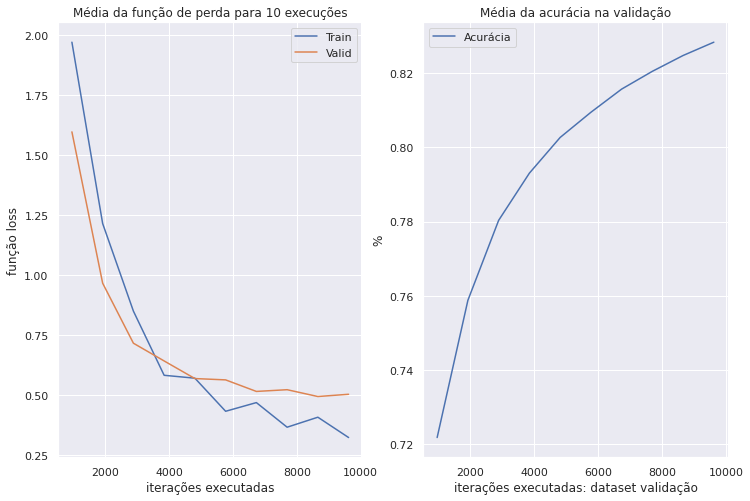

In [86]:
saida = obtem_media_metricas_treino(id_planilha = 9, plota_grafico=True)
train = saida



#sns.lineplot(x = saida[2], y = saida[0],  label = 'Train', legend='full', palette=palette )
#sns.lineplot(x = saida[2], y = saida[1], label = 'Valid', legend='full', palette=palette)

In [ ]:
tr, val = saida[0], saida[1]
print(tr)
print('*********')
print(val)
print(saida[3])

[1.9797321353781498, 1.2262125705390114, 0.8884329620957869, 0.5443104564880259, 0.5359930427655918, 0.3859786471441048, 0.4068133172786285, 0.31806380672693996, 0.33409302611941794, 0.2763346302522474]
*********
[1.8102519807479194, 1.236344969433373, 0.6741376399313761, 0.5722380291005883, 0.4803473806912969, 0.4527767292629633, 0.41764698454267746, 0.4007591712524287, 0.38826150595214354, 0.3771960971521453]
[0.5627338877338877, 0.6128378378378379, 0.6898648648648649, 0.7297297297297297, 0.7572765072765073, 0.7761954261954263, 0.790889515889516, 0.8025402806652806, 0.8116250866250867, 0.8194490644490646]


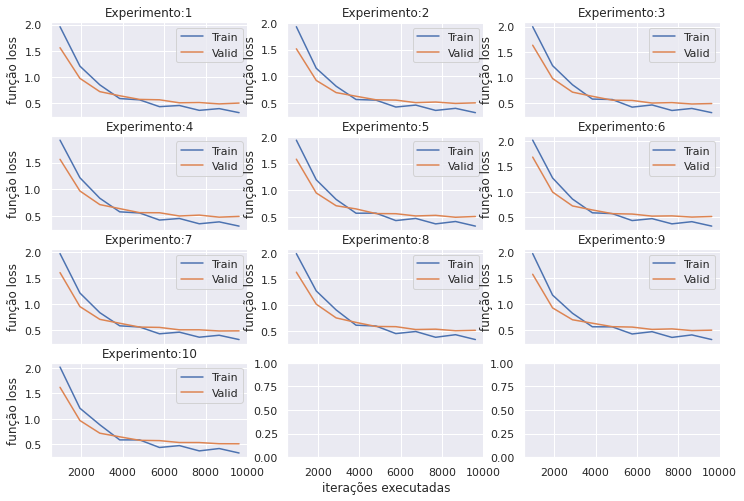

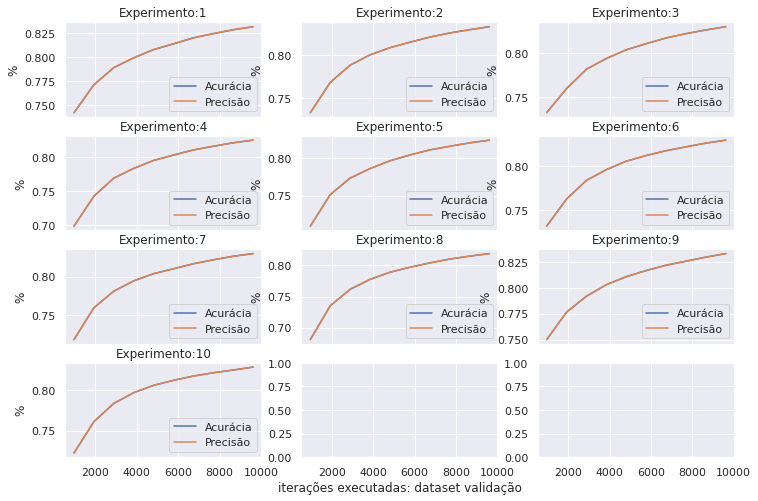

In [ ]:
analisa_treinamento(id_planilha = 9) #max_seq_length=128


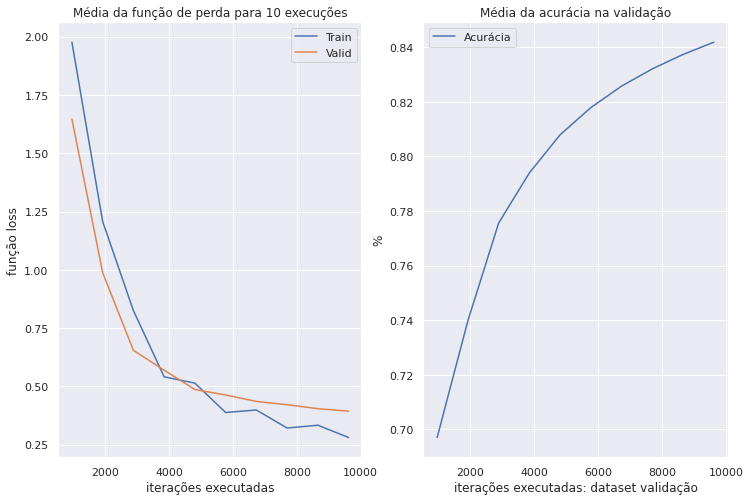

In [ ]:
saida  = obtem_media_metricas_treino(id_planilha = 9.1, plota_grafico=True)

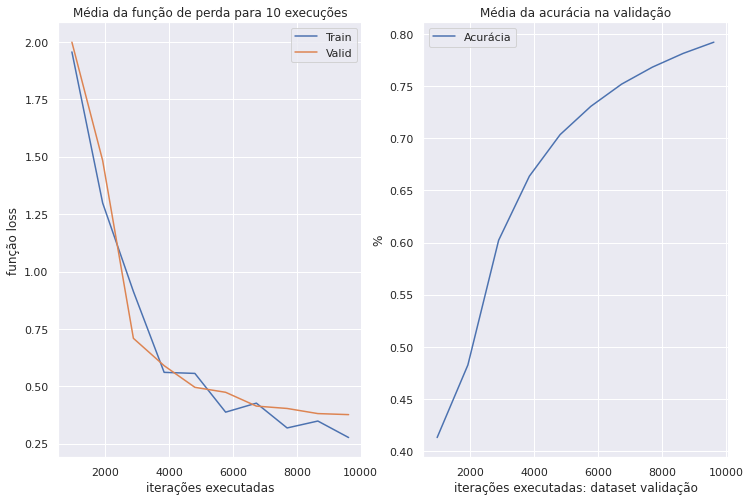

In [ ]:
saida = obtem_media_metricas_treino(id_planilha = 9.2, plota_grafico=True)

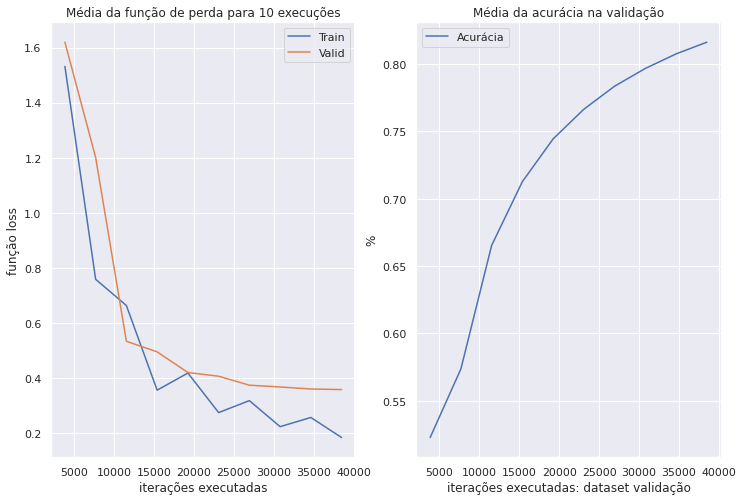

In [ ]:
saida = obtem_media_metricas_treino(id_planilha = '9.2/bs2/', plota_grafico=True) #analisa_treinamento(id_planilha = '9.2/bs2/')
#saida = obtem_media_metricas_treino(id_planilha = '9.2/bs4/', plota_grafico=True) #analisa_treinamento(id_planilha = '9.2/bs4/')


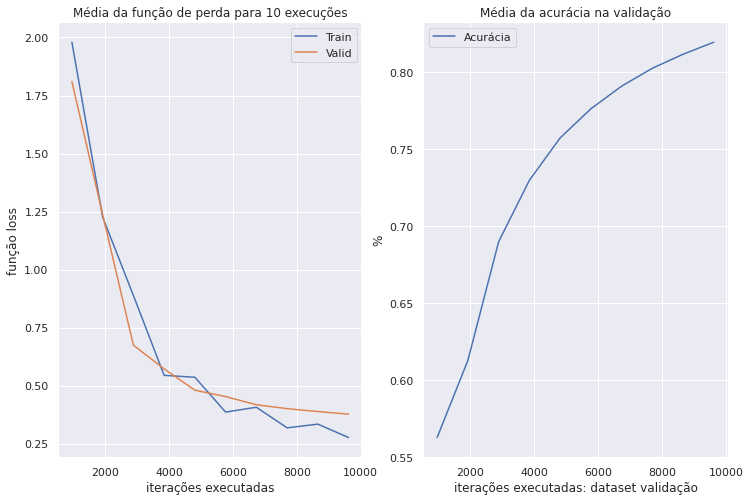

In [ ]:
saida = obtem_media_metricas_treino(id_planilha = '9.4', plota_grafico=True)

1  2  3  4  5  6  7  71  72  9	9.1  9.2  9.3  9.4  9.9  999


# AVALIANDO O MODELO

In [13]:
def avalia_modelo(id_planilha, n):
  dataset = 5
  gerais=[]
  porclasse=[]
  X_saida = []
  y_hat = []
  file_path = processo.destination_folder + "/"+str(id_planilha)
  for idx  in range(n):
    seed= 420 + idx*10
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    file_path = processo.destination_folder + "/"+str(id_planilha)+'/'+str(idx)
    best_model = BERT(qtd_categories=processo.qtd_categorias).to(processo.device)
    processo.load_checkpoint(file_path + '/model.pt', best_model)
    tokens = processo.tokenizaAmostra(processo.source_folder+str(dataset),soTeste=True)
    X_saida_teste, y_true, y_pred = processo.evaluate(best_model, tokens[2]) #tokens[2] é o dataset de teste
    dctMetricas, dfPorClasse = processo.obtemMetricas(y_true,y_pred)    
    gerais.append(dctMetricas)
    porclasse.append(dfPorClasse)
    X_saida.append(X_saida_teste)
    y_hat.append(y_pred)
    del(best_model)
  return[gerais, porclasse, X_saida, y_hat, y_true]
  
def obtem_metrica_por_classe(porclasse):
  frame=[]
  for i, df in enumerate(porclasse):
    df['classe']= df.index.tolist()
    df['teste']=i
    frame.append(df)

  dfMetricas = pd.concat(frame, sort=False)
  frame=[]
  for classe in range(10):
    dfClasse = dfMetricas[dfMetricas['classe']==str(classe)]
    dfDesc = pd.DataFrame(dfClasse.describe().reset_index().drop(['support','teste'],axis=1).rename(columns={'index':'medida'}))
    dfDesc['classe']=classe
    frame.append(dfDesc)
  dfMedidas = pd.concat(frame, sort=False)
  dfMedidas = dfMedidas[(dfMedidas['medida']=='mean') | (dfMedidas['medida']=='std')] # (dfMedidas['medida']=='std')
  dfMedidas.sort_values(by=['medida','classe']).reset_index().drop('index',axis=1).T
  return dfMedidas

def obtem_metricas_gerais(gerais):
  frame=[]
  for i, dct in enumerate(gerais):
    df = pd.DataFrame.from_dict(dct, orient='index') #.reset_index().rename(columns={'index':'metrica'})
    df['experimento']=i
    frame.append(df)
  dfGerais = pd.concat(frame, sort=False).reset_index().rename(columns={'index':'medida',0:'valor'})
  frame=[]
  for medida in dfGerais['medida'].unique().tolist():
    dftmp = dfGerais[dfGerais['medida']==medida].describe().reset_index().rename(columns={'index':'medida'})[['medida','valor']]
    dftmp['metrica'] = medida
    frame.append(dftmp[(dftmp['medida']=='mean') | (dftmp['medida']=='std')])
  return pd.concat(frame,sort=False)

def imprime_grafico_porclasse(dfMedidas, y):
  g = sns.catplot(x='medida', y=y, hue='classe', data=dfMedidas, kind='bar', height=8.0)
  g.fig.set_size_inches(15,8)
  g.fig.subplots_adjust(top=0.81,right=0.86)  
  g.fig.suptitle('Média e Desvio Padrão da ' + y +  ' para as 10 execuções de Tamanho de Sequência = ' +  str(processo.MAX_SEQ_LEN))

  ax = g.facet_axis(0,0)
  for p in ax.patches:
      ax.text(p.get_x() , 
              p.get_height() , 
            '{0:.2f}'.format(p.get_height()),  
              color='black', 
              rotation='horizontal', 
              )#size='large'

def imprime_grafico_MetricasGerais(dfMedidas):
  g = sns.catplot(x='medida', y='valor', hue='metrica', data=dfMedidas, kind='bar', height=8.0)
  g.fig.set_size_inches(15,8)
  g.fig.subplots_adjust(top=0.81,right=0.86)  
  g.fig.suptitle('Média e Desvio Padrão das métricas = ' +  str(processo.MAX_SEQ_LEN))

  ax = g.facet_axis(0,0)
  for p in ax.patches:
      ax.text(p.get_x() , 
              p.get_height() , 
            '{0:.2f}'.format(p.get_height()),  
              color='black', 
              rotation='horizontal', 
              size='large')

## PRECISÃO, RECALL, F1-SCORE PARA CADA CLASSE

In [85]:


frameGerais = []
frame_porClasse =[] 
SaidaRede = {}
y_hat ={}
Ld_y_true ={}
id_planilha = ['9','9.1','9.2','9.2/bs2/','9.2/bs4/','9.4'] #
seq_length = [ 128,256, 512, 512, 512, 394] #
bs = [ 8, 8, 2, 4, 8, 8] #
for i, id_ in enumerate(id_planilha):
  processo = BERTimbau_Noticias(tokenizer = tokenizer,
                              max_seq_length = seq_length[i],
                              bs=bs[i],
                              lr=1e-06,
                              qtd_categorias=10)
  gerais, porclasse, X_saida_teste, y_pred, y_true = avalia_modelo(id_planilha=id_, n=1)
  df_mean_std_porclasse = obtem_metrica_por_classe(porclasse)
  df_mean_std_geral = obtem_metricas_gerais(gerais)
  frameGerais.append(df_mean_std_geral)
  frame_porClasse.append( df_mean_std_porclasse)
  SaidaRede[id_] = X_saida_teste
  y_hat[id_] = y_pred
  Ld_y_true[id_] = y_true
  ###gravando
  ''' f = open(destination_folder + "/" +  id_ + "/" +   "gerais.pkl", "wb")
  pickle.dump(df_mean_std_geral, f)
  f.close
  f = open(destination_folder + "/" + id_ + "/" +   "por_classe.pkl", "wb")
  pickle.dump(df_mean_std_porclasse, f)
  f.close
  f = open(destination_folder + "/" + id_ + "/" +   "saidaRede.pkl", "wb")
  pickle.dump(X_saida_teste, f)
  f.close
  f = open(destination_folder + "/" + id_ + "/" +   "y_hat.pkl", "wb")
  pickle.dump(y_hat, f)
  f.close
  f = open(destination_folder + "/" + id_ + "/" +   "y_true.pkl", "wb")
  pickle.dump(y_true, f)
  f.close'''

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/0/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.1/0/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.2/0/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.2/bs2//0/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.2/bs4//0/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9.4/0/model.pt


In [86]:
len(X_saida_teste[0])

1925

In [ ]:
'''for i, id_ in enumerate(id_planilha):
  f = open(destination_folder + "/" +  id_ + "/" +   "gerais.pkl", "wb")
  pickle.dump(frameGerais[i], f)
  f.close
  f = open(destination_folder + "/" + id_ + "/" +   "por_classe.pkl", "wb")
  pickle.dump(frame_porClasse[i], f)
  f.close
  f = open(destination_folder + "/" + id_ + "/" +   "saidaRede.pkl", "wb")
  pickle.dump(SaidaRede[i], f)
  f.close
  f = open(destination_folder + "/" + id_ + "/" +   "y_hat.pkl", "wb")
  pickle.dump(y_hat[i], f)
  f.close'''

In [14]:
id_planilha = ['9','9.1','9.2','9.2/bs2/','9.2/bs4/','9.4'] 
Ld_gerais=[]
Ld_por_classe=[]
Ld_Saida=[] #cada posição tem um dicionário com o resultados do experimento (são 10 execuções, i.e values tem uma lista com 10 listas de resultado)
Ld_y_hat=[]
Ld_y_true=[]
for i, id_ in enumerate(id_planilha):
  f = open(destination_folder + "/" +  id_ + "/" +   "gerais.pkl", "rb")
  Ld_gerais.append(pickle.load(f))
  f.close()
  f = open(destination_folder + "/" + id_ + "/" +   "por_classe.pkl", "rb")
  Ld_por_classe.append(pickle.load(f))
  f.close()
  f = open(destination_folder + "/" + id_ + "/" +   "saidaRede.pkl", "rb")
  Ld_Saida.append(pickle.load(f))
  f.close()
  f = open(destination_folder + "/" + id_ + "/" +   "y_hat.pkl", "rb")
  Ld_y_hat.append(pickle.load(f))
  f.close()
  #f = open(destination_folder + "/" + id_ + "/" +   "y_true.pkl", "rb")
  #Ld_y_true.append(pickle.load(f))
  #f.close()

In [30]:
dfGerais = Ld_gerais[0]
dfGerais.head(10)

,medida,valor,metrica
1,mean,0.882857,acuraccy
2,std,0.002415,acuraccy
1,mean,0.879671,balanced_accuracy
2,std,0.002580,balanced_accuracy
1,mean,0.882857,precision_global
2,std,0.002415,precision_global
1,mean,0.881148,precision_local
2,std,0.002607,precision_local
1,mean,0.882857,recall_global
2,std,0.002415,recall_global


In [31]:
experimento = '1','2','3','3: bs=2','3: bs=4','4'
frame=[]
for i, g in enumerate(Ld_gerais):
  dfGerais = g
  dfGerais = dfGerais[dfGerais['metrica'].isin(['acuraccy', 'balanced_accuracy', 'cohen_kappa', 'precision_local', 'recall_local'])]
  df = dfGerais.groupby(['medida','metrica'])['valor'].mean().reset_index()
  df['experimento'] = experimento[i]
  if experimento[i] == '3: bs=2':
    dfx = df
  elif experimento[i] == '3: bs=4':
    frame.append(df)
    frame.append(dfx)
  else:
    frame.append(df)
dfGerais = pd.concat(frame,sort='False')
#por classe
frame=[]
for i, g in enumerate(Ld_por_classe):
  df = Ld_por_classe[i]
  df['experimento'] = experimento[i]
  if experimento[i] == '3: bs=2':
    dfx = df
  elif experimento[i] == '3: bs=4':
    frame.append(df)
    frame.append(dfx)
  else:
    frame.append(df)
df_porClasse = pd.concat(frame,sort='False')

In [136]:
def categoria(nro):
  cat = ['política', 'economia', 'esporte', 'mundo', 'ilustrada', 'mídia', 'tecnologia', 'educação', 'saúde', 'ciência']
  return cat[nro]

In [ ]:
#GERADOR DE TABELAS PARA O LATEX
medida = 'mean'

cat = [categoria(i) for i in range(0,10)]
cat.append('acurácia')
for idx in df_porClasse['experimento'].unique():
  print('#############################', idx ,'############################')
  dfx = df_porClasse[(df_porClasse['medida']==medida) & (df_porClasse['experimento']==idx) ].reset_index().copy()
  if medida == 'std':
    dfx['categoria'] = dfx['classe'].map(lambda x: categoria(x))
    dfx['precision'] = pd.Series([" & ${0:.3f}\%$  ".format(val) for val in dfx['precision']], index = dfx.index)
    dfx['recall'] = pd.Series([" & ${0:.3f}\%$  ".format(val  ) for val in dfx['recall']], index = dfx.index)
    #dfx['specificity'] = pd.Series([" & ${0:.2f}\%$ ".format(val * 100) for val in dfx['specificity']], index = dfx.index)
    dfx['f1-score'] = pd.Series([" & ${0:.3f}\%$  & ".format(val ) for val in dfx['f1-score']], index = dfx.index)
  else:
    dfx['categoria'] = dfx['classe'].map(lambda x: categoria(x))
    dfx['precision'] = pd.Series([" & ${0:.2f}\%$  ".format(val*100) for val in dfx['precision']], index = dfx.index)
    dfx['recall'] = pd.Series([" & ${0:.2f}\%$  ".format(val*100  ) for val in dfx['recall']], index = dfx.index)
    #dfx['specificity'] = pd.Series([" & ${0:.2f}\%$ ".format(val * 100) for val in dfx['specificity']], index = dfx.index)
    dfx['f1-score'] = pd.Series([" & ${0:.2f}\%$  & ".format(val*100 ) for val in dfx['f1-score']], index = dfx.index)
  dfx[['categoria', 'precision', 'recall', 'f1-score']]
  print(dfx[['categoria', 'precision', 'recall', 'f1-score']])

In [38]:
#display(dfGerais[dfGerais['experimento']=='4'].reset_index())
#display(dfGerais[dfGerais['experimento']=='3: bs=4'].reset_index())
#display(dfGerais[dfGerais['experimento']=='3: bs=2'].reset_index())

,index,experimento,medida,metrica,valor
0,0,4,mean,acuraccy,0.905662
1,1,4,mean,balanced_accuracy,0.901795
2,2,4,mean,cohen_kappa,0.895032
3,3,4,mean,precision_local,0.904767
4,4,4,mean,recall_local,0.901795
5,5,4,std,acuraccy,0.003456
6,6,4,std,balanced_accuracy,0.004127
7,7,4,std,cohen_kappa,0.003849
8,8,4,std,precision_local,0.003325
9,9,4,std,recall_local,0.004127


In [47]:
'hed' not in 'hederson'

False

In [50]:
dfGerais

,experimento,medida,metrica,valor
0,1,mean,acuraccy,0.882857
1,1,mean,balanced_accuracy,0.879671
2,1,mean,cohen_kappa,0.869661
3,1,mean,precision,0.881148
4,1,mean,recall,0.879671
5,1,std,acuraccy,0.002415
6,1,std,balanced_accuracy,0.002580
7,1,std,cohen_kappa,0.002688
8,1,std,precision,0.002607
9,1,std,recall,0.002580


Text(0.5, 0, 'experimento')

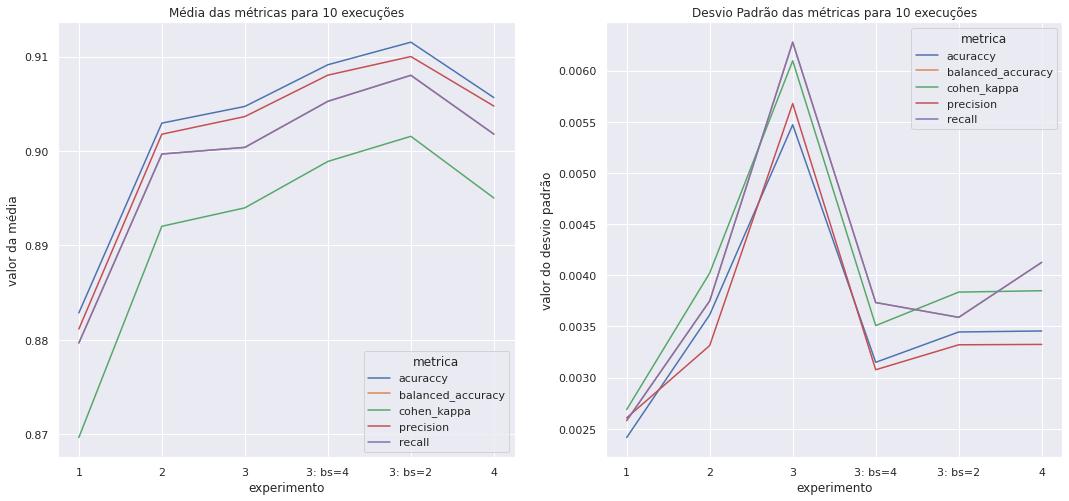

In [51]:
dfGerais['metrica'] = dfGerais.loc[:,['metrica']].apply(lambda x: x['metrica'].replace('_local','') if '_local' in x['metrica'] else x['metrica'], axis=1)
dfmean = dfGerais[dfGerais['medida']=='mean'].reset_index()
dfstd = dfGerais[dfGerais['medida']=='std'].reset_index()
#sns.lineplot(df.experimento, y=df.valor, hue=df.metrica)
fig, ax =plt.subplots(1,2, figsize=(18, 8), sharex=True)
sns.lineplot(x = dfmean.experimento, y = dfmean.valor,  hue=dfmean.metrica, legend='full',   ax=ax[0])
sns.lineplot(x = dfstd.experimento, y = dfstd.valor,  hue=dfstd.metrica, legend='full',  ax=ax[1])
#sns.lineplot(x = global_steps, y = mean_valid_precision, label = 'Precisão', legend='full', palette=palette, ax=ax[1])
ax[0].set_title('Média das métricas para 10 execuções')  
ax[1].set_title('Desvio Padrão das métricas para 10 execuções' )
ax[0].set_ylabel('valor da média')
ax[1].set_ylabel('valor do desvio padrão')
ax[0].set_xlabel('experimento')
ax[1].set_xlabel('experimento')

In [ ]:
#NÃO USAR ESTE - GRÁFICO DE BARRAS É RUIM!!!
'''dfmean = df_porClasse[df_porClasse['medida']=='mean'].reset_index()
dfstd = df_porClasse[df_porClasse['medida']=='std'].reset_index()
#sns.lineplot(df.experimento, y=df.valor, hue=df.metrica)
fig, ax =plt.subplots(1,3, figsize=(22, 8), sharex=True)
sns.barplot(x = dfmean.experimento, y = dfmean.precision,  palette=palette,  ax=ax[0])
sns.barplot(x = dfmean.experimento, y = dfmean.recall,  palette=palette,  ax=ax[1])
sns.barplot(x = dfmean.experimento, y = dfmean['f1-score'],  palette=palette,  ax=ax[2])
#sns.lineplot(x = global_steps, y = mean_valid_precision, label = 'Precisão', legend='full', palette=palette, ax=ax[1])
ax[0].set_title('Média da precisão para as 10 execuções')  
ax[1].set_title('Média da revocação para as 10 execuções' )
ax[2].set_title('Média da f1-score para as 10 execuções' )
ax[0].set_ylabel('precisão média')
ax[1].set_ylabel('revocação média')
ax[2].set_ylabel('f1-score média')
ax[0].set_xlabel('experimento')
ax[1].set_xlabel('experimento')
ax[2].set_xlabel('experimento')'''

In [ ]:
###GRÁFICO RUIM ###
'''dfstd = df_porClasse[df_porClasse['medida']=='std'].reset_index()
#sns.lineplot(df.experimento, y=df.valor, hue=df.metrica)
fig, ax =plt.subplots(1,3, figsize=(22, 8), sharex=True)
sns.barplot(x = dfstd.experimento, y = dfstd.precision,  palette=palette,  ax=ax[0])
sns.barplot(x = dfstd.experimento, y = dfstd.recall,  palette=palette,  ax=ax[1])
sns.barplot(x = dfstd.experimento, y = dfstd['f1-score'],  palette=palette,  ax=ax[2])
#sns.lineplot(x = global_steps, y = mean_valid_precision, label = 'Precisão', legend='full', palette=palette, ax=ax[1])
ax[0].set_title('Desvio Padrão Médio da precisão para as 10 execuções')  
ax[1].set_title('Desvio Padrão Médio da revocação para as 10 execuções' )
ax[2].set_title('Desvio Padrão Médio da f1-score para as 10 execuções' )
ax[0].set_ylabel('desvio padrão médio')
ax[1].set_ylabel('desvio padrão médio')
ax[2].set_ylabel('desvio padrão médio')
ax[0].set_xlabel('experimento')
ax[1].set_xlabel('experimento')
ax[2].set_xlabel('experimento')'''

In [262]:
from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, confusion_matrix, \
                            plot_confusion_matrix, classification_report, \
                            balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef, \
                            auc, roc_curve, precision_recall_curve
def imprimeROC_PrecisonRecall_curvas(y_teste,predicted_prob):
  classes = np.unique(y_teste)
  y_test_array = pd.get_dummies(y_teste, drop_first=False).values
  fig, ax = plt.subplots(figsize=(12,8),nrows=1, ncols=2)
  ## Plot roc
  for i in range(len(classes)):
      fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                            predicted_prob[:,i])
      ax[0].plot(fpr, tpr, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                auc(fpr, tpr))
                )
  ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
  ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
            xlabel='Taxa Falso Positivo ', 
            ylabel="Taxa Verdadeiro Positivo", 
            title="Receiver operating characteristic")
  ax[0].legend(loc="lower right")
  ax[0].grid(True)

  ## Plot precision-recall curve
  for i in range(len(classes)):
      precision, recall, thresholds = precision_recall_curve(
                  y_test_array[:,i], predicted_prob[:,i])
      ax[1].plot(recall, precision, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                    auc(recall, precision))
                )
  ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
            ylabel="Precision", title="Precision-Recall curve")
  ax[1].legend(loc="best")
  ax[1].grid(True)
  plt.show()

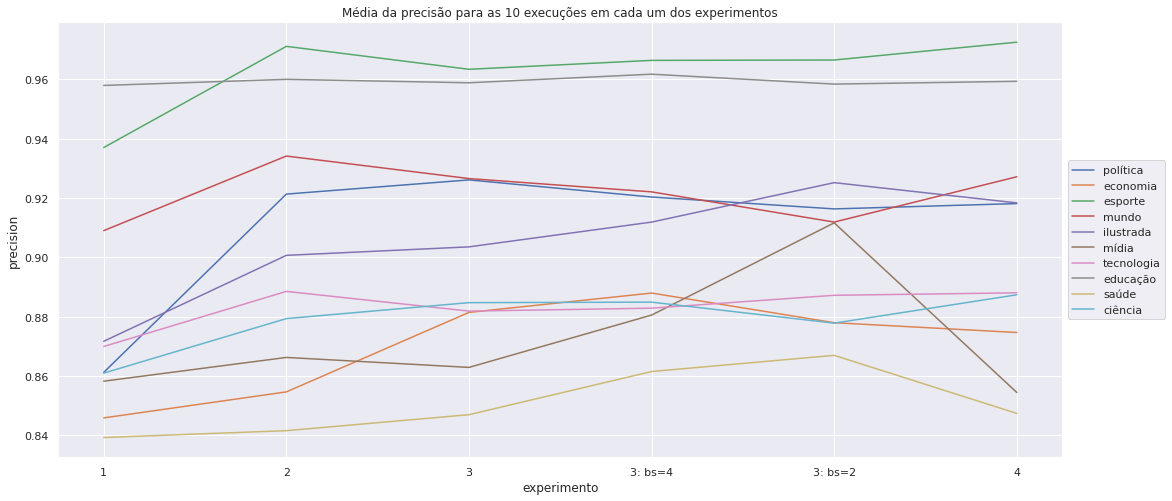

In [81]:
#MEDIAS DAS PRECISOES
fig, ax =plt.subplots(1, figsize=(18, 8))
#fig = figsize=(18, 8)
for i in range(10):
  df_cl = df_porClasse[(df_porClasse['medida']=='mean') & (df_porClasse['classe']==i)].reset_index()
  #df_cl_sd = df_porClasse[(df_porClasse['medida']=='std') & (df_porClasse['classe']==i)].reset_index()
  sns.lineplot(df_cl['experimento'], y=df_cl['precision'], legend='full' )
  #sns.lineplot(df_cl_sd['experimento'], y=df_cl_sd['precision'], legend=False, ax=ax[1] )
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
               labels=['política', 'economia', 'esporte', 'mundo', 'ilustrada', 'mídia', 'tecnologia', 'educação', 'saúde', 'ciência'])
  ax.set_title('Média da precisão para as 10 execuções em cada um dos experimentos')



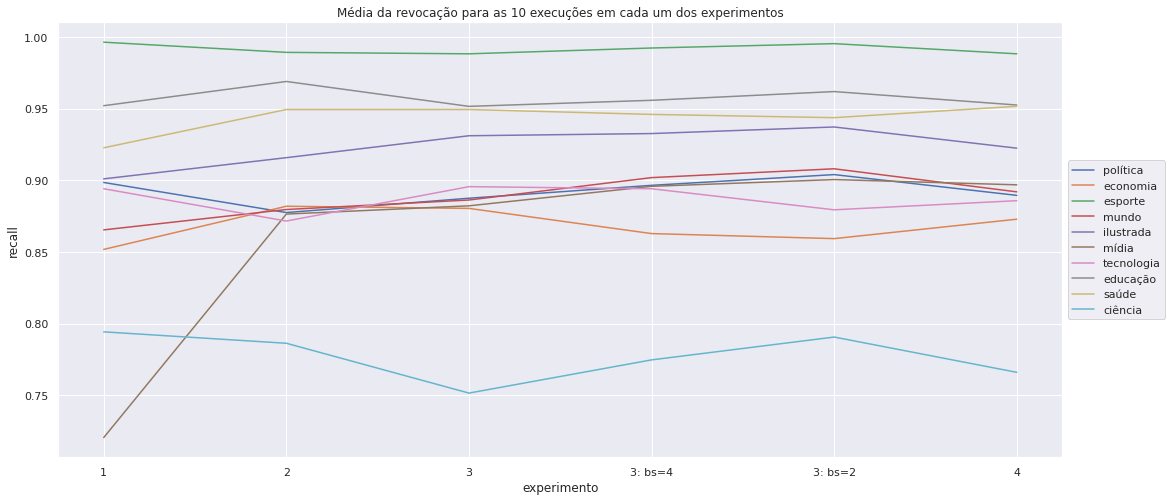

In [84]:
#MEDIAS DAS REVOCACOES
fig, ax =plt.subplots(1, figsize=(18, 8))
#fig = figsize=(18, 8)
for i in range(10):
  df_cl = df_porClasse[(df_porClasse['medida']=='mean') & (df_porClasse['classe']==i)].reset_index()
  #df_cl_sd = df_porClasse[(df_porClasse['medida']=='std') & (df_porClasse['classe']==i)].reset_index()
  sns.lineplot(df_cl['experimento'], y=df_cl['recall'], legend='full' )
  #sns.lineplot(df_cl_sd['experimento'], y=df_cl_sd['precision'], legend=False, ax=ax[1] )
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
               labels=['política', 'economia', 'esporte', 'mundo', 'ilustrada', 'mídia', 'tecnologia', 'educação', 'saúde', 'ciência'])
  ax.set_title('Média da revocação para as 10 execuções em cada um dos experimentos')

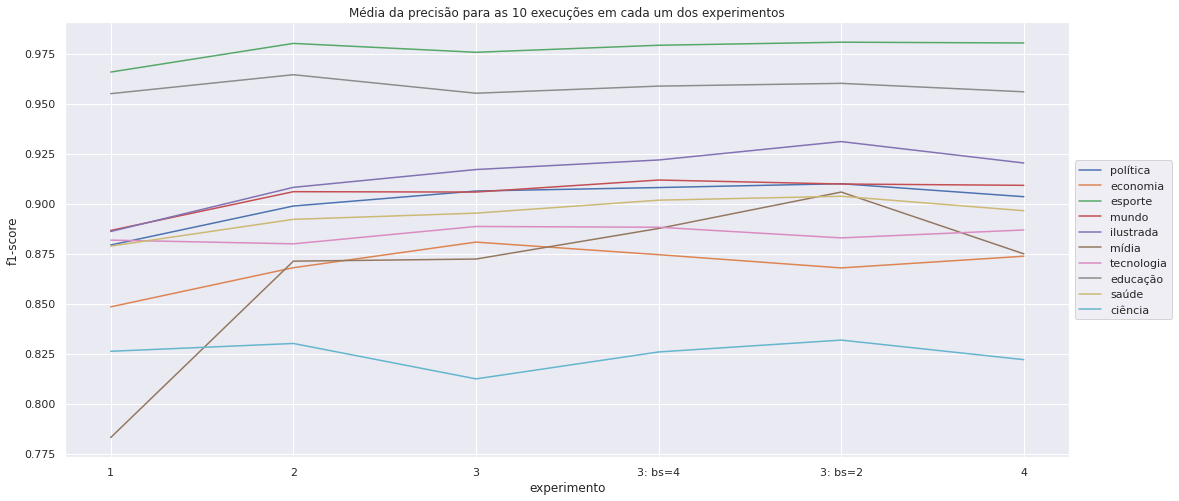

In [83]:
#MEDIAS DAS F1-SCORE
fig, ax =plt.subplots(1, figsize=(18, 8))
#fig = figsize=(18, 8)
for i in range(10):
  df_cl = df_porClasse[(df_porClasse['medida']=='mean') & (df_porClasse['classe']==i)].reset_index()
  #df_cl_sd = df_porClasse[(df_porClasse['medida']=='std') & (df_porClasse['classe']==i)].reset_index()
  sns.lineplot(df_cl['experimento'], y=df_cl['f1-score'], legend='full' )
  #sns.lineplot(df_cl_sd['experimento'], y=df_cl_sd['precision'], legend=False, ax=ax[1] )
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
               labels=['política', 'economia', 'esporte', 'mundo', 'ilustrada', 'mídia', 'tecnologia', 'educação', 'saúde', 'ciência'])
  ax.set_title('Média da precisão para as 10 execuções em cada um dos experimentos')

In [111]:
Ld_y_true['9']

6

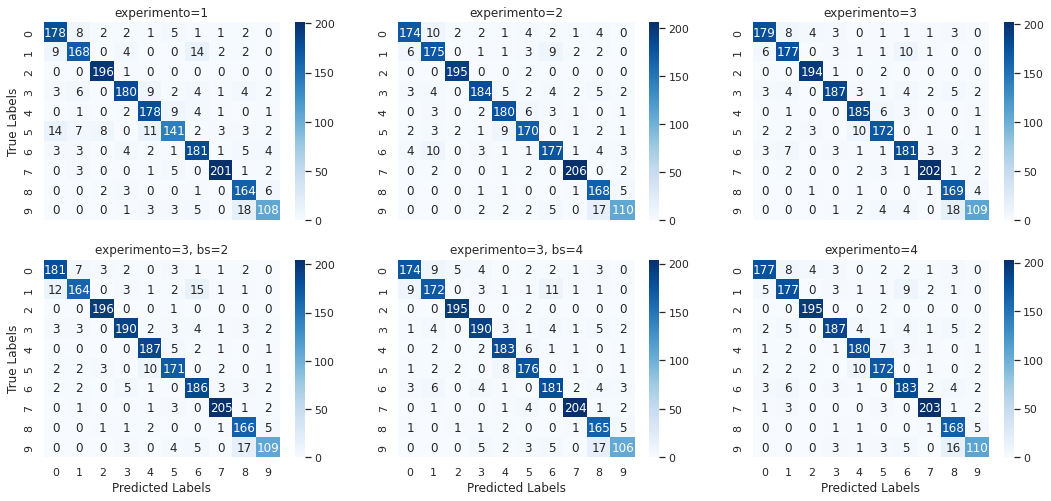

In [112]:
from sklearn.metrics import confusion_matrix
#obtem o y_hat e o y_true do treino 1/10 de cada experimento. Não está gravado em disco. Deve rodar a rotina de geração dos valores de avaliação para pegar y_hat e y_true
id_planilha = ['9','9.1','9.2','9.2/bs2/','9.2/bs4/','9.4'] 
titulo = ['experimento=1', 'experimento=2', 'experimento=3','experimento=3, bs=2', 'experimento=3, bs=4', 'experimento=4' ]
fig, ax =plt.subplots(2,3, figsize=(18, 8), sharex=True)
r,c=0,0
for i, k in enumerate(y_hat.keys()):
  y_pred = y_hat[k][0]
  y_true = Ld_y_true[k]
  cm = confusion_matrix(y_true, y_pred, labels=np.arange(0,10))
  sns.heatmap(cm, annot=True, ax = ax[r,c], cmap='Blues', fmt="d")

  ax[r,c].set_title(titulo[i])

  if  r==1:
    ax[r,c].set_xlabel('Predicted Labels')
  if c==0:
    ax[r,c].set_ylabel('True Labels')
  if c<2:
    c+=1
  else:
    c=0
    r=1


In [117]:
len(Ld_Saida[0][0])



1925

## MÉTRICAS GERAIS: ACURÁCIA, ACURÁCIA BALANCEADA, COHEN KAPPA, PRECISÃO REVOCAÇÃO

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1925 samples in 0.002s...
[t-SNE] Computed neighbors for 1925 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1925
[t-SNE] Computed conditional probabilities for sample 1925 / 1925
[t-SNE] Mean sigma: 0.279133
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.399742
[t-SNE] KL divergence after 1000 iterations: 0.593578
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1925 samples in 0.002s...
[t-SNE] Computed neighbors for 1925 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1925
[t-SNE] Computed conditional probabilities for sample 1925 / 1925
[t-SNE] Mean sigma: 0.289839
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.138641
[t-SNE] KL divergence after 1000 iterations: 0.584402
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1925 samples in 0.002s...
[t-SNE] Computed neighbors for 1925 samples in 0

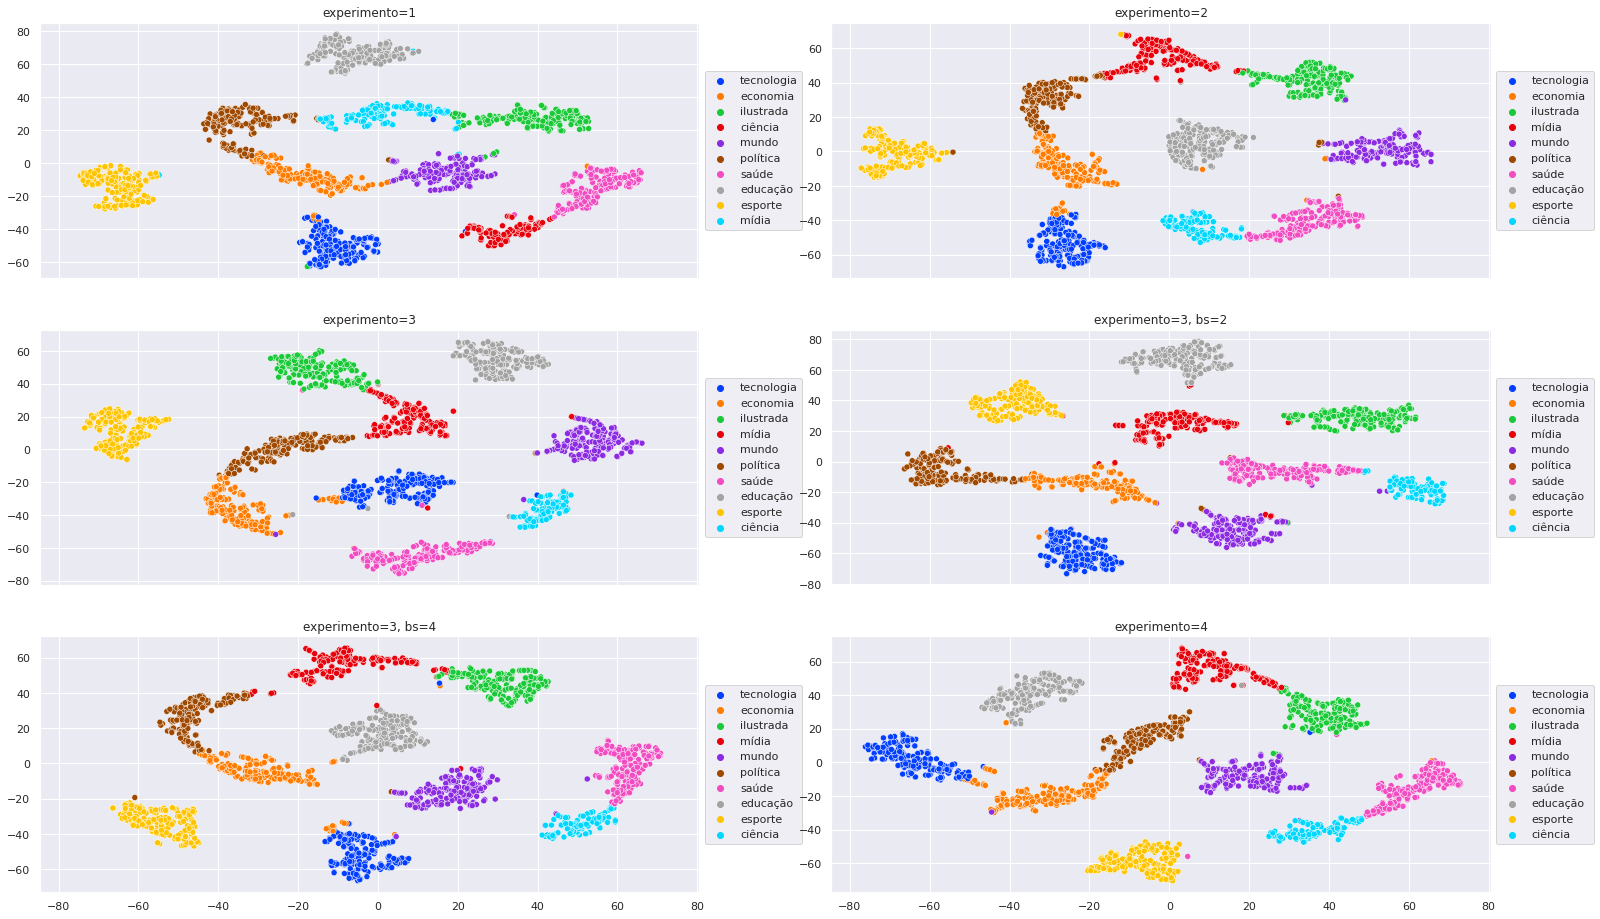

In [144]:
#X_saida = Ld_Saida[0][0]
#y_pred =  y_hat['9'][0]
#processo.imprimeGraficosReducaoDimensaoTSNE(X_saida, y_pred)
id_planilha = ['9','9.1','9.2','9.2/bs2/','9.2/bs4/','9.4'] 
titulo = ['experimento=1', 'experimento=2', 'experimento=3','experimento=3, bs=2', 'experimento=3, bs=4', 'experimento=4' ]

fig, ax =plt.subplots(3,2, figsize=(26, 16), sharex=True)
r,c=0,0
for i, k in enumerate(y_hat.keys()):
  X_saida = Ld_Saida[i][0]
  y_pred =  y_hat[k][0]
  X_embedded = processo.reducaoDimensaoTSNE(X_saida)
  cat_nome = [categoria(y) for y in y_pred]
  sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=cat_nome,ax = ax[r,c], palette=palette)
  ax[r,c].legend(loc='center left', bbox_to_anchor=(1, 0.5))
  ax[r,c].set_title(titulo[i])
  if c<1:
    c+=1
  else:
    c=0
    r+=1

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1925 samples in 0.003s...
[t-SNE] Computed neighbors for 1925 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1925
[t-SNE] Computed conditional probabilities for sample 1925 / 1925
[t-SNE] Mean sigma: 0.300375
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.461960
[t-SNE] KL divergence after 1000 iterations: 0.576702


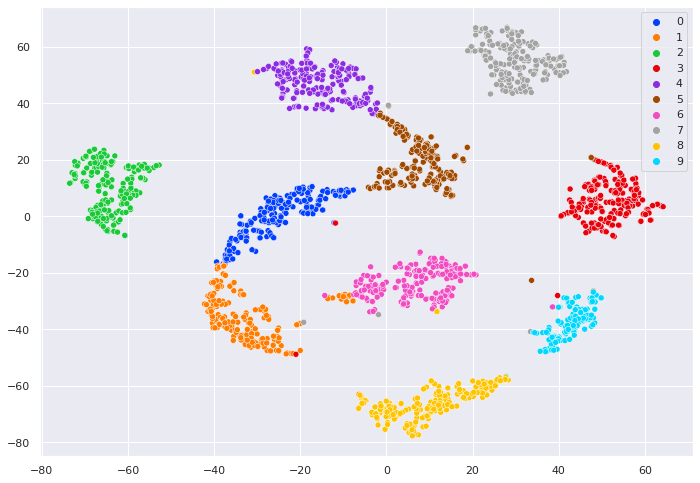

In [ ]:
X_saida = Ld_Saida[2][0]
y_pred = Ld_y_hat[2][0]
processo.imprimeGraficosReducaoDimensaoTSNE(X_saida, y_pred)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1925 samples in 0.003s...
[t-SNE] Computed neighbors for 1925 samples in 0.067s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1925
[t-SNE] Computed conditional probabilities for sample 1925 / 1925
[t-SNE] Mean sigma: 0.357933
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.269890
[t-SNE] KL divergence after 1000 iterations: 0.586317


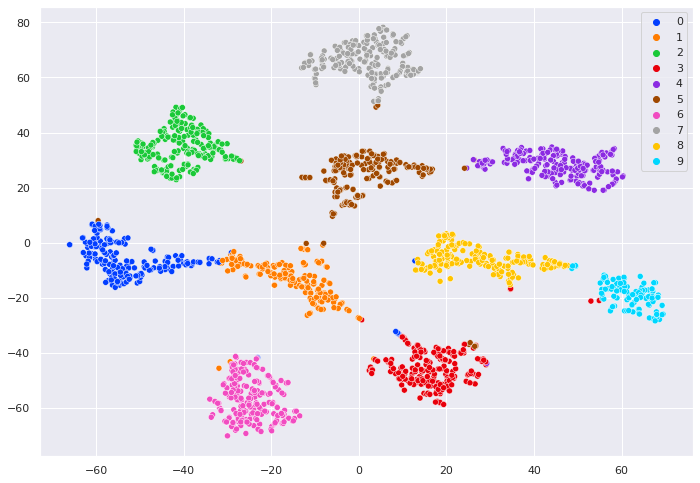

In [ ]:
X_saida = Ld_Saida[3][0]
y_pred = Ld_y_hat[3][0]
processo.imprimeGraficosReducaoDimensaoTSNE(X_saida, y_pred)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1925 samples in 0.005s...
[t-SNE] Computed neighbors for 1925 samples in 0.080s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1925
[t-SNE] Computed conditional probabilities for sample 1925 / 1925
[t-SNE] Mean sigma: 0.329278
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.139462
[t-SNE] KL divergence after 1000 iterations: 0.566581


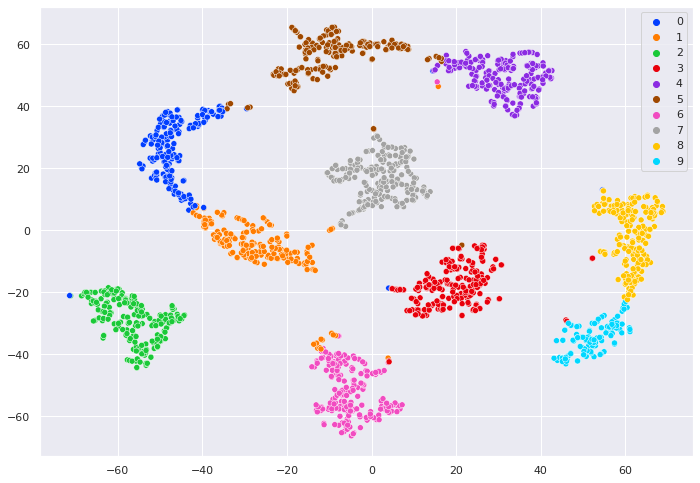

In [ ]:
X_saida = Ld_Saida[4][0]
y_pred = Ld_y_hat[4][0]
processo.imprimeGraficosReducaoDimensaoTSNE(X_saida, y_pred)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1925 samples in 0.006s...
[t-SNE] Computed neighbors for 1925 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1925
[t-SNE] Computed conditional probabilities for sample 1925 / 1925
[t-SNE] Mean sigma: 0.291044
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.287392
[t-SNE] KL divergence after 1000 iterations: 0.574125


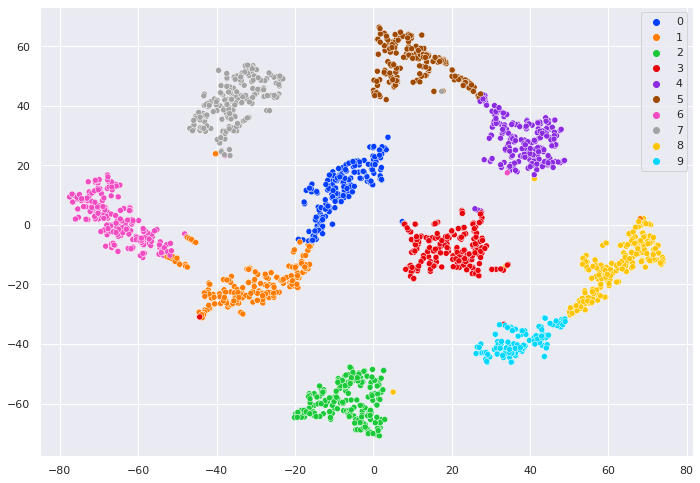

In [ ]:
X_saida = Ld_Saida[5][0]
y_pred = Ld_y_hat[5][0]
processo.imprimeGraficosReducaoDimensaoTSNE(X_saida, y_pred)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1925 samples in 0.003s...
[t-SNE] Computed neighbors for 1925 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1925
[t-SNE] Computed conditional probabilities for sample 1925 / 1925
[t-SNE] Mean sigma: 0.277174
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.293026
[t-SNE] KL divergence after 1000 iterations: 0.566510


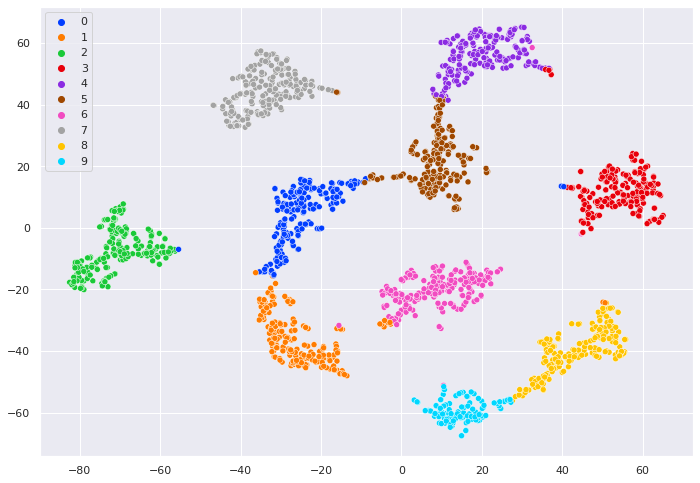

In [ ]:
X_saida = Ld_Saida[5][1]
y_pred = Ld_y_hat[5][1]
processo.imprimeGraficosReducaoDimensaoTSNE(X_saida, y_pred)